## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

Using TensorFlow backend.


<Response [200]>

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""

# Define customed loss
# def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fcl_weights=0.3):  # # 參考解答版本
def combined_loss(ce_weight, gamma=2., alpha=4.):
    
    gamma = float(gamma)
    alpha = float(alpha)
    
    """Define the customized loss."""
    def combined_loss_keras(y_true, y_pred):
        
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        
        ce = tf.multiply(y_true, -tf.log(model_out)) # cross entropy
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma)) # weight
        fl = tf.multiply(alpha, tf.multiply(weight, ce)) # focal_loss
        
        reduced_fl = tf.reduce_max(fl, axis=1) # reduced cross entropy
        reduced_ce = tf.reduce_max(ce, axis=1) # reduced focal_loss
#       ce_loss    = keras.losses.categorical_crossentropy(y_true, y_pred) # # 參考解答版本
        
        # 定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy (比例不要寫死)
        return tf.reduce_mean((1-ce_weight) * reduced_fl + (ce_weight) * reduced_ce)
#       return (ce_weights*ce_loss) + (fcl_weights*tf.reduce_mean(reduced_fl) ) # # 參考解答版本
    
    return combined_loss_keras


ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [8]:
import itertools
results = {}
for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    """
    # 在 compile 時，使用自定義的 loss function
    """
    # 用 combined_loss(ce_w) 因為現在迭代的代號 for i, ce_w in ...
    model.compile(loss = combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (B

50000/50000 [==============================] - 1s 28us/step - loss: 2.6593 - accuracy: 0.5569 - val_loss: 3.2587 - val_accuracy: 0.4675
Epoch 8/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.5453 - accuracy: 0.5720 - val_loss: 3.3016 - val_accuracy: 0.4704
Epoch 9/25
50000/50000 [==============================] - 1s 29us/step - loss: 2.4356 - accuracy: 0.5878 - val_loss: 3.2646 - val_accuracy: 0.4693
Epoch 10/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.3289 - accuracy: 0.6017 - val_loss: 3.2400 - val_accuracy: 0.4720
Epoch 11/25
50000/50000 [==============================] - 1s 29us/step - loss: 2.2291 - accuracy: 0.6143 - val_loss: 3.1654 - val_accuracy: 0.4798
Epoch 12/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.1245 - accuracy: 0.6273 - val_loss: 3.2049 - val_accuracy: 0.4824
Epoch 13/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.0433 - accuracy: 0.6411 - val_loss: 3.2322 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 2s 36us/step - loss: 3.4126 - accuracy: 0.3014 - val_loss: 3.4855 - val_accuracy: 0.2120
Epoch 2/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.5731 - accuracy: 0.4187 - val_loss: 3.1051 - val_accuracy: 0.3051
Epoch 3/25
50000/50000 [==============================] - 1s 29us/step - loss: 2.3570 - accuracy: 0.4590 - val_loss: 2.7720 - val_accuracy: 0.3825
Epoch 4/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.2233 - accuracy: 0.4847 - val_loss: 2.6046 - val_accuracy: 0.4019
Epoch 5/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.1189 - accuracy: 0.5059 - val_loss: 2.4472 - val_accuracy: 0.4387
Epoch 6/25
50000/50000 [==============================] - 1s 28us/step - loss: 2.0355 - accuracy: 0.5237 - val_loss: 2.3849 - val_accuracy: 0.4471
Epoch 7/25
50000/50000 [==============================] - 1s 28us/st

Epoch 21/25
50000/50000 [==============================] - 1s 29us/step - loss: 1.0464 - accuracy: 0.6431 - val_loss: 1.4417 - val_accuracy: 0.4959
Epoch 22/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.0250 - accuracy: 0.6508 - val_loss: 1.4470 - val_accuracy: 0.4995
Epoch 23/25
50000/50000 [==============================] - 1s 28us/step - loss: 1.0060 - accuracy: 0.6584 - val_loss: 1.4480 - val_accuracy: 0.4974
Epoch 24/25
50000/50000 [==============================] - 1s 28us/step - loss: 0.9861 - accuracy: 0.6651 - val_loss: 1.4420 - val_accuracy: 0.5019
Epoch 25/25
50000/50000 [==============================] - 1s 29us/step - loss: 0.9662 - accuracy: 0.6746 - val_loss: 1.4554 - val_accuracy: 0.4985


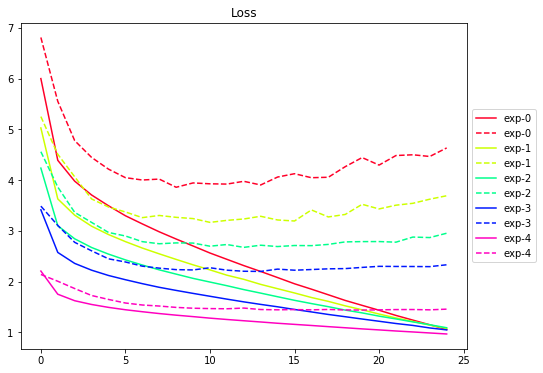

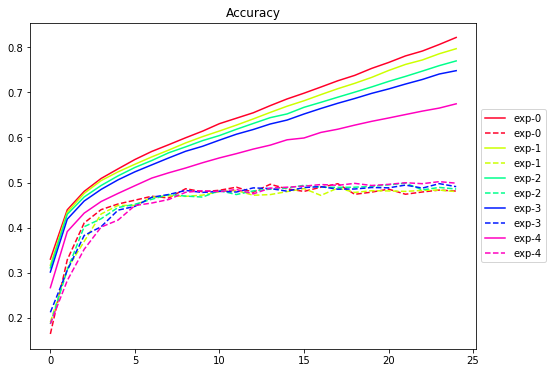

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()